<a href="https://colab.research.google.com/github/marcelopinheiro42-tech/MEC503-Topicos_especiais_mecanica_solidos/blob/main/Marcelo_Pinheiro_AtvPINN_AE2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MARCELO JOEL DOS SANTOS PINHEIRO

RA 24202331032

MEC-502 Topico Especial da Mecanica dos Solidos

GitHub : Marcelo_Pinheiro_AtvPINN_AE2b.ipynb

**EXERCICIO 1b**

1) Implemente em PyTorch uma PINN para encontar o deslocamento no problema da barra unidirecional apresentado Fig 1.

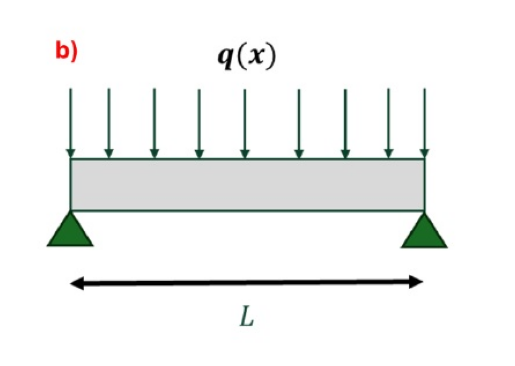

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mping
img_path = '/content/Fig2b Barra bi-apoiada com carga distribuida.jpg'
img = mping.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

**Solução Analitica do problema**


Integrando uma vez em relação a (x):

(1) $$EI\frac{dv}{dx} = \frac{P}{2}(x^2 - Lx)$$

Integrando primeira vez:

(2) $$EI\frac{dv}{dx} = \frac{P}{2}\left(\frac{x^3}{3} - \frac{Lx^2}{2} + C_1\right)$$

Integrando pela sengunda vez em relação a (x):

(3) $$EIv = \frac{P}{2}\left(\frac{x^4}{12} - \frac{Lx^3}{6} + C_1x + C_2\right)$$


Aplicando as condições de contorno $x = L$ em $V(L) = 0$ para encontrar a constante de integração $C_1$ e $x = 0$ em $V(0) = 0$ para encontrar $C_2$:

  1. Condição de contorno em $x = L$ em $V(L) = 0$

  $$0 = \frac{P}{2}\left(\frac{L^4}{12} - \frac{L^4}{6} + C_1L + C_2\right) $$

 Portanto:  $$C_1 = \frac{L^3}{12}$$

  2. Condição de contorno em $x = 0$ em $V(0) = 0$

  $$0 = \frac{P}{2}\left(\frac{(0)^4}{12} - \frac{L(0)^4}{6} + C_1(0) + C_2\right)$$

Portanto:  $$C_2 = 0$$

  Logo, $C_1$ e $C_2$, substituindo esses resultados nas equações 2  e 3 onde $θ =\frac{dv}{dx}$, obtemos:  

  $$θ = \frac{P}{2EI}(L^2 - x^2)$$   

  $$v = \frac{P}{6EI}(-x^3 + 3L^2x - 2L^3)$$                                  

Portanto, para a solução analítica quando a inclinação e o deslocamento máximos ocorrem em $(x = L/2)$, para o qual:

   $$Vmax = \frac{3PL^4}{384EI}$$

Portanto, para a solução analítica quando a inclinação máxima ocorrem em $(x = 0)$ e $(x = L)$, para o qual:

$$ θ max= \frac{PL^3}{24EI}$$

**Instalar DeepXDE**

In [ ]:
! pip install -q deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde
import torch
dde.backend.backend_name = "pytorch"

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


**Parâmetros do problema:**


*   Módulo de elasticidade $E = 21000kN/cm^2$ ou $E = 210.000.000kN/m^2$
*   Momento de inercia $I = 22500 cm^4$ ou $I = 0,00225m^4$
*   Comprimento da barra $L = 6m$
*   Carga Distribuida  $q = 2 kN/m$





**Valores calculador:**

1) Deslocamento $v$;

$$Vmáx = \frac{3(2.6)(6)^4}{384(2100000000).(0,00225)}$$

$$v = 0,0000257m$$

2) Angulo $θ:$

$$θmáx = \frac{(2.6).(6)^3}{24.(2100000000). 0,00225}$$

$$θ = 0,0000228º$$

In [ ]:
E = 2100000000
I = 0.00225
L = 6
P = 12

**Solução analítica**

In [ ]:
def func(x):
  return ((3*P*L**4)/(384*E*I))

**Definindo o Intervalo**

In [ ]:
geom = dde.geometry.geometry_1d.Interval(0, L)

**Derivadas 1 e 2 ordem**

In [ ]:
# Derivadas de ordem 2
def ddy(x, y):
  return dde.grad.hessian(y, x)

# Derivada de Ordem 1 da Derivada de Ordem 2 ( 3 Derivada)
def dddy(x, y):
  return dde.grad.jacobian(ddy(x, y), x)

# Definicao da EDO do problema
def pde(x, y):
    # Chamando a funcao da derivada segunda
    dy_xx = ddy(x, y)
    # Usando o Hessiano para derivar duas vezes (4 ordem)
    dy_xxxx = dde.grad.hessian(dy_xx, x)
    return E*I*dy_xxxx + P

**Condição de Contorno:**

In [ ]:
def boundary_l(x, on_boundary):
  return on_boundary and np.isclose(x[0], 0)

def boundary_r(x, on_boundary):
  return on_boundary and np.isclose(x[0], L)

bc1 = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_l)
bc2 = dde.icbc.NeumannBC(geom, lambda x: 0, boundary_l)
bc3 = dde.icbc.OperatorBC(geom, lambda x, y, _: ddy(x, y), boundary_r)
bc4 = dde.icbc.OperatorBC(geom, lambda x, y, _: dddy(x, y), boundary_r)

**Dados para o DeepXDE**

In [ ]:
data = dde.data.PDE(
    geom,
    pde,
    [bc1, bc2, bc3, bc4],
    num_domain=10,
    num_boundary=2,
)

**Criação da rede**

In [ ]:
layer_size = [1] + [20]*3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001)
#model.train()
N_iter = 8000
step = 50
LossHistory, train_state = model.train(iterations=N_iter, display_every=step)

Compiling model...
Building feed-forward neural network...
'build' took 0.073078 s

'compile' took 2.756828 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [2.16e+12, 0.00e+00, 1.98e-01, 5.73e-05, 8.26e-06]    [2.16e+12, 0.00e+00, 1.98e-01, 5.73e-05, 8.26e-06]    []  
50        [3.81e+09, 2.86e-04, 5.91e-05, 7.36e-06, 6.03e-08]    [3.81e+09, 2.86e-04, 5.91e-05, 7.36e-06, 6.03e-08]    []  
100       [2.41e+08, 2.25e-06, 8.96e-05, 7.83e-06, 4.47e-08]    [2.41e+08, 2.25e-06, 8.96e-05, 7.83e-06, 4.47e-08]    []  
150       [8.68e+07, 1.24e-06, 1.67e-05, 7.30e-06, 4.09e-08]    [8.68e+07, 1.24e-06, 1.67e-05, 7.30e-06, 4.09e-08]    []  
200       [3.91e+07, 3.79e-07, 1.00e-05, 6.56e-06, 5.23e-08]    [3.91e+07, 3.79e-07, 1.00e-05, 6.56e-06, 5.23e-08]    []  
250       [1.91e+07, 1.38e-07, 9.21e-06, 5.90e-06, 6.10e-08]    [1.91e+07, 1.38e-07, 9.21e-06, 5.90e-06, 6.10e-08]    []  
30

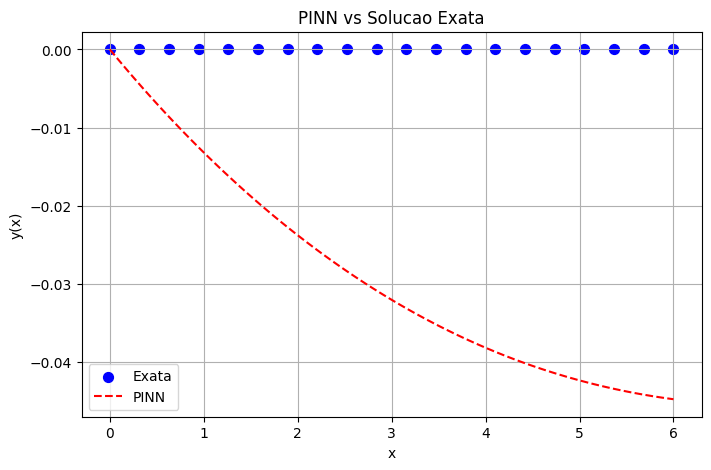

In [ ]:
# Definindo X_PINN e Y_PINN
x_pinn = np.linspace(0,L,100).reshape(-1,1)
y_pinn = model.predict(x_pinn)

# Calculo da solucao exata
x_exato = np.linspace(0,L,20).reshape(-1,1)
y_exato = np.array([func(x) for x in x_exato])

# Plotando a PINN vs a solucao exata
plt.figure(figsize=(8,5))
plt.scatter(x_exato, y_exato, label = 'Exata', color = 'blue', marker = "o", s = 50)
plt.plot(x_pinn, y_pinn, label = 'PINN', color = "red", linestyle = "--")
plt.xlabel("x")
plt.ylabel("y(x)")
plt.title("PINN vs Solucao Exata")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Curva da funçoes de perda da PDE, ICBCs e Total
losses = np.array(LossHistory.loss_train)
print(np.shape(losses))
pde_loss_plot = losses[:,0]
icbc_loss_plot = np.array(np.sum(losses[:,1:],1))
print(np.shape(icbc_loss_plot))
total_loss_plot = pde_loss_plot + icbc_loss_plot

(161, 5)
(161,)


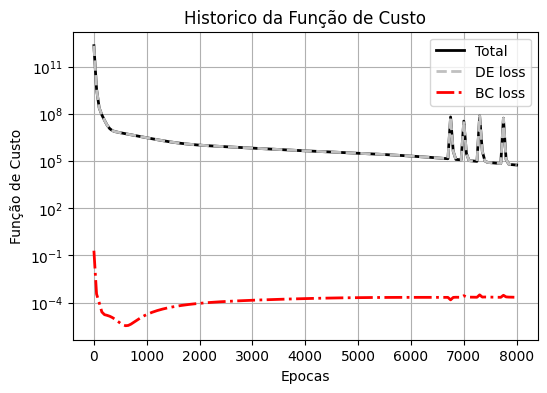

In [ ]:
plt.figure(figsize=(6,4))
epocas = np.linspace(0,N_iter,np.size(pde_loss_plot))
plt.plot(epocas,total_loss_plot, 'k', linewidth=2, label="Total")
plt.plot(epocas,pde_loss_plot, color='silver', linestyle='--', linewidth=2, label="DE loss")
plt.plot(epocas,icbc_loss_plot, color='r', linestyle='-.', linewidth=2, label="BC loss")

plt.xlabel('Epocas')
plt.ylabel('Função de Custo')
plt.yscale('log')
plt.title('Historico da Função de Custo')
plt.legend()
plt.grid(True)
plt.show()